# LMUNet: Infer LSMs

**ORIGINAL SOURCE:** [Top 100 solution - SIIM-ACR Pneumothorax Segmentation](https://amaarora.github.io/2020/09/06/siimacr.html#train-and-valid-augmentations)

The Data-structure should look like this (old names: 

```
├── data
│   ├── dataset512
│   ├── dicom-images-test
│   └── dicom-images-train
├── outputs
│   ├── dataset512
│   ├── dicom-images-test
│   └── dicom-images-train
├── data
│   ├── dataset512
│   ├── dicom-images-test
│   └── dicom-images-train
├── data
│   ├── dataset512
│   ├── dicom-images-test
│   └── dicom-images-train
├── data
├── data
├── data
├── data
├── data
├── data
├── data
├── data
├── data
└── src
    └── pneumothorax-segmentation 
```


## Preparations

### Imports

remove obsolete ones

In [1]:
#from LMUnet_Imports import import_modules
#%run LMUnet_Imports.py

In [1]:
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
from torch.nn import MSELoss
from torcheval.metrics import MeanSquaredError, R2Score
from torcheval.metrics.functional import r2_score
import torch.nn.functional as F # for padding/interpolation

# dataset and unet (could also add to this file, hmm!
from Dataset_test_many_metrics import LandscapeMetricsDataset
from unet_num_metr import unet#, Decoder

from LMUnet_custom_loss_functions import MSELossNan, HuberLossNan
from LMUnet_r2_one_by_one import r2_one_by_one, r2_one_by_one_dict, r2_nan
from LMUnet_visualization_functions import visualize

from DenormNameApplyNan import DenormNameApplyNan

# Optimization specific imports
from LMUnet_optimize_one_landscape import optimize_one_landscape
from LMUnet_connected_component_labeling import connected_component_labeling, find_largest_patch
from LMUnet_graph_operations import add_edges, get_largest_neighbor
from IPython.display import clear_output
import networkx as nx

block_test torch.Size([1, 64, 128, 128])
encoder_test torch.Size([1, 64, 128, 128])
encoder_test torch.Size([1, 128, 64, 64])
encoder_test torch.Size([1, 256, 32, 32])
encoder_test torch.Size([1, 512, 16, 16])
decoder_test torch.Size([1, 64, 64, 64])
unet_output_dim_test torch.Size([1, 1, 128, 128])


### b) Config (Hyperparameters)

In [2]:
# Working with the original dataset, the test set.
#%run LMUnet_Config_57_metrics_reverse

In [5]:
TESTING_MODE = 'test_dataset'
#TESTING_MODE = 'example_landscape'
#TESTING_MODE = 'corine'

In [6]:
DATA_DIR         = Path(f'../notebooks/data')

METRIC_NAME = 'multi_metrics_66'
TRAIN_METRIC     = f'100k_5cl_{METRIC_NAME}'
METRIC_NAMES = pd.read_csv(f'data/{METRIC_NAME}.csv', header=None)[0]   

# Load list for which channel carries which metric
metr_norm        = pd.read_csv('metr_norm.csv', header=None).values.tolist()

TRAIN_LBL_DIR    = DATA_DIR/TRAIN_METRIC # 100k 5 class
OUTPUT_DIR       = Path(f'outputs/landscape_testiing/{TRAIN_METRIC}')
TRAIN_LOG        = OUTPUT_DIR/'output_log.txt'

print(TRAIN_LBL_DIR)
print(OUTPUT_DIR)

DEVICE           = 'cuda'
LEARNING_RATE    = 2e-5
EPOCHS           = 2000000 #10000000 #10000
LOSS_FN          = 'HL_NAN' #'MSE_NAN' #'HL_NAN' #'HL' # HuberLoss ['MSE','RMSE','MAE' 'HL is combined mae and ... rmse
EVAL_FN          = 'R2' # ['MSE']
USE_CRIT         = True
NUM_WORKERS      = 0 

FROM_PREDICTED = False


mean_std = 'mean_std.csv'
mean_std = pd.read_csv(mean_std, header=None)
mean_std = {mean_std.iloc[row][0]:[mean_std.iloc[row][1], mean_std.iloc[row][2]] for row in range(len(mean_std))}

../notebooks/data/100k_5cl_multi_metrics_66
outputs/landscape_testiing/100k_5cl_multi_metrics_66


In [7]:
if TESTING_MODE == 'test_dataset':
        
    TRAIN_IMG_DIR    = DATA_DIR/'100k_landscapes_5_class' # 5 class 100k
    TRAIN_DF         = pd.read_csv('data/100k_joinent_5_class_metric_list.csv', header=None) #100k 5 class
    
    # Split into training, validation and testing dataset
    DATASET_LENGHTS  = [80000,15000,5000]
    #INPUT_LS_DIR = 'data/100k_random_landscape_noises'
    full_dataset = LandscapeMetricsDataset(TRAIN_DF, TRAIN_IMG_DIR, TRAIN_LBL_DIR, 
                                               metr_norm=metr_norm, mean_std=mean_std)

    # Which landscape from the test dataset to work with
    LS_NUMBER = 1 #95001 # 11

    # Generate split with same sets as original training due to seed
    train_dataset, valid_dataset, test_dataset = random_split(dataset=full_dataset, 
                                                            lengths=DATASET_LENGHTS,
                                                            generator=torch.Generator().manual_seed(42))

    # Assign targets
    target_landscape, target_metric = test_dataset[LS_NUMBER]['landscape'], test_dataset[LS_NUMBER]['metric']

# If predicting the example landscape
elif TESTING_MODE == 'example_landscape':
    target_landscape = np.load('data/example_landscape/example_landscape_landscape/ls_example_landscape_reflect.npy')
    #target_metric    = np.load('data/example_landscape/example_landscape_multi_metrics_52/metr_example_landscape.npy')
    target_metric    = np.load('data/example_landscape/ex_ls_padded_metrics_normalized.npy')

# If predicting the corine landscape
elif TESTING_MODE == 'corine':
    target_landscape = np.load('data/example_landscape_corine/corine_goettingen_padded_stacked.npy')
    # to be added properly
    ##target_metric    = np.load('data/example_landscape/example_landscape_multi_metrics_52/metr_example_landscape.npy')
    
    
# Sanity check; Should be 1,1,128,128, 1,57,128,128
target_landscape.shape, target_metric.shape

(torch.Size([1, 128, 128]), torch.Size([57, 128, 128]))

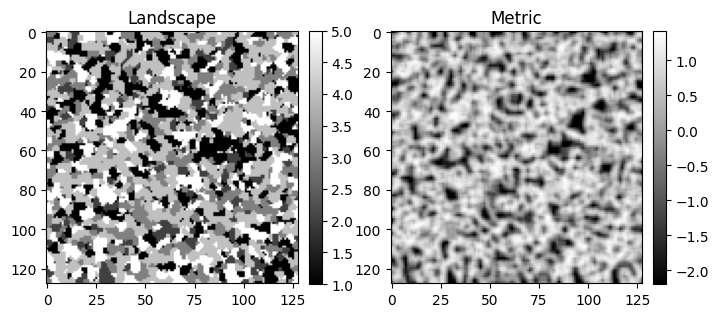

In [8]:
# Visualize target landscape and metric
visualize(target_landscape.squeeze(), 
          target_metric[51].squeeze())

## Loss and Model

### i) Loss

In [9]:
#%run LMUnet_custom_loss_functions.py

In [10]:
if LOSS_FN == 'MAE':
    criterion = nn.L1Loss()

elif LOSS_FN == 'MSE' or LOSS_FN == 'RMSE':
    criterion = nn.MSELoss()  

elif LOSS_FN == 'HL':
    criterion = nn.HuberLoss()
    
elif LOSS_FN == 'MSE_NAN':
    criterion = MSELossNan()
    
elif LOSS_FN == 'HL_NAN':
    criterion = HuberLossNan()
    
criterion

HuberLossNan()

### j) Model

From [PyTorch Segmentation Models](https://github.com/qubvel/segmentation_models.pytorch):

In [11]:
#%run unet_num_metr.py

In [12]:
NUM_METRICS = target_metric.shape[0]

# Conventionally:
model = unet(num_metr=NUM_METRICS)

# For Binary one hot:
#model = unet(enc_chs=(4,64,128,256,512), num_metr=NUM_METRICS)

#model = model.half()

In [14]:
# Original reduced learning rate
PRETRAINED_PATH = 'outputs/saved_models/100k_5cl_multi_metrics_66_adjusted/bst_model_100k_5cl_multi_metrics_66_bs:16_nw:0_nm:57_lf:HL_NAN_ep:34_0.9707_lr:8.1e-07.bin'

# Padding with reflect and normalized input
#PRETRAINED_PATH = 'outputs/saved_models/100k_5cl_multi_metrics_66_ls_norm/bst_model_100k_5cl_multi_metrics_66_bs:16_nw:0_nm:57_lf:HL_NAN_ep:78_0.9545_lr:2.0e-05.bin'

# Add noise
#PRETRAINED_PATH = 'outputs/saved_models/100k_5cl_multi_metrics_66_add_noise/bst_model_100k_5cl_multi_metrics_66_bs:16_nw:0_nm:57_lf:HL_NAN_ep:68_0.9282_lr:1.9e-07.bin'

# Binary pretrained
#PRETRAINED_PATH = 'outputs/saved_models/100k_5cl_multi_metrics_66_one_hot/bst_model_100k_5cl_multi_metrics_66_bs:16_nw:0_nm:57_lf:HL_NAN_ep:98_0.9689_lr:2.0e-05.bin'

# Load pretrained model
model.load_state_dict(torch.load(PRETRAINED_PATH))

# If optimizing from the predicted metrics instead of the original ones
if FROM_PREDICTED:
    target_metric = model(target_landscape.unsqueeze(0))

# Infer metrics

In [1]:
# Load your landscape (if not done above)
target_landscape = np.load('...')

In [ ]:
# Convert to tensor and add to device (if not done above)
target_landscape = torch.from_numpy(target_landscape).to('cuda').to(torch.float32)

In [ ]:
# Ensure that landscape is of shape B, C, H, W
# If not: target_landscape.unsqueeze(0) to add empty dimension
target_landscape.shape, target_metric.shape

In [ ]:
# Predict LSMs
predicted_metric = model(target_landscape)

In [ ]:
# Calulate average loss score for all metrics
loss_score = criterion(predicted_metric, target_metric)

In [ ]:
# Calculate r2 score for every individual metric
r2_scores = r2_one_by_one(predicted_metric, target_metric)

In [ ]:
# Visualize all predicted metrics next to target metric
for metric_num in range(57):
    metric_name = metr_norm[metric_num][1]
    visualize(target_metric[0][metric_num], 
              predicted_metric[0][metric_num], 
              left_title=f'Target Metric {metric_name}', 
              right_title='Predicted Metric {metric_name}',
              # optionally: save images to file
             #savefilepath=f'..._{metric_name}.png'
             )

In [ ]:
# Save predicted_metric.npy to file:
np.save('file_path.npy', predicted_metric)